In [393]:
cd D:\RMSC5002

D:\RMSC5002


In [394]:
import warnings
warnings.filterwarnings('ignore')

In [435]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
#import quandl
import numpy as np
from scipy.stats import zscore
from sklearn.linear_model import LogisticRegression
from pylab import rcParams

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
    classification_report,
    precision_recall_curve
)
from sklearn import metrics

In [396]:
rcParams['figure.figsize'] = 16, 9

In [397]:
#np.set_printoptions(suppress=True)
pd.options.display.float_format = '{:.6f}'.format

### Read the data

In [398]:
cr_df = pd.read_csv('credit_risk_dataset.csv')

In [399]:
cr_df.tail()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
32576,57,53000,MORTGAGE,1.000000,PERSONAL,C,5800,13.160000,0,0.110000,N,30
32577,54,120000,MORTGAGE,4.000000,PERSONAL,A,17625,7.490000,0,0.150000,N,19
32578,65,76000,RENT,3.000000,HOMEIMPROVEMENT,B,35000,10.990000,1,0.460000,N,28
32579,56,150000,MORTGAGE,5.000000,PERSONAL,B,15000,11.480000,0,0.100000,N,26
32580,66,42000,RENT,2.000000,MEDICAL,B,6475,9.990000,0,0.150000,N,30


## Data Preparation

### Finding columns that are numeric

In [400]:
vcol = cr_df.select_dtypes(include=["int64", "float64"]).columns.tolist()

### Scale the columns

In [401]:
def MinMaxScale(x):
    return (x - min(x))/(max(x) - min(x))

In [402]:
cr_df[vcol] = cr_df[vcol].apply(MinMaxScale)

In [403]:
cr_df['loan_status'] = cr_df['loan_status'].astype('int')

### Create Dummy Variables for Categorical Data

In [404]:
data = pd.get_dummies(
    cr_df,
    columns=['person_home_ownership','loan_intent','loan_grade','cb_person_default_on_file'],
    drop_first=False,
)

In [405]:
data.columns

Index(['person_age', 'person_income', 'person_emp_length', 'loan_amnt',
       'loan_int_rate', 'loan_status', 'loan_percent_income',
       'cb_person_cred_hist_length', 'person_home_ownership_MORTGAGE',
       'person_home_ownership_OTHER', 'person_home_ownership_OWN',
       'person_home_ownership_RENT', 'loan_intent_DEBTCONSOLIDATION',
       'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT',
       'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE',
       'loan_grade_A', 'loan_grade_B', 'loan_grade_C', 'loan_grade_D',
       'loan_grade_E', 'loan_grade_F', 'loan_grade_G',
       'cb_person_default_on_file_N', 'cb_person_default_on_file_Y'],
      dtype='object')

### Drop some columns

In [406]:
#data = data.drop(['person_home_ownership_OTHER','loan_intent_PERSONAL','loan_grade_G',
#           'cb_person_default_on_file_N'],axis=1)
data = data.drop(['cb_person_default_on_file_N'],axis=1)

### Remove missing data

In [407]:
data = data.dropna().reset_index().drop(['index'],axis=1)

### Split the data for training and testing

In [408]:
data.groupby('loan_status').size()

loan_status
0    22435
1     6203
dtype: int64

**Data for class 0 is substantially larger than that for class 1.**

We extract 70% of class 1 records and match 1-1 of class 0 records.

In [409]:
def train_test_split(data, r=0.7):
    arr = data.index.tolist()
    np.random.shuffle(arr)
    m = np.floor(len(data)*r).astype('int')
    train_idx = list(arr[:m])
    test_idx = list(arr[m:])
    return train_idx, test_idx

In [410]:
train_idx1, test_idx1 = train_test_split(data[data['loan_status']==1])
train_idx0, test_idx0 = train_test_split(data[data['loan_status']==0],r=0.2)

In [411]:
len(train_idx0), len(train_idx1)

(4487, 4342)

In [430]:
train_data = data.loc[train_idx0+train_idx1]
test_data1 = data.loc[test_idx1]
test_data0 = data.loc[test_idx0]

## Discriminant Analysis

### Find covariance matrix of the variables

In [413]:
cols = [x for x in data.columns if x != 'loan_status']
train_data[cols].cov()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
person_age,0.002518,0.000051,0.000297,0.000657,0.000134,-0.000263,0.006452,0.000974,-0.000002,-0.000067,...,0.000344,-0.000296,-0.000052,-0.000278,-0.000095,0.000356,-0.000031,0.000048,0.000052,0.000296
person_income,0.000051,0.000059,0.000048,0.000527,0.000022,-0.000371,0.000111,0.001050,0.000012,-0.000046,...,0.000044,-0.000028,-0.000008,0.000020,-0.000098,-0.000012,0.000045,0.000040,0.000013,-0.000019
person_emp_length,0.000297,0.000048,0.001173,0.000808,-0.000396,-0.000312,0.000707,0.003813,-0.000036,0.000203,...,0.000079,-0.000035,0.000851,0.000177,-0.000401,-0.000345,-0.000300,-0.000040,0.000057,-0.000273
loan_amnt,0.000657,0.000527,0.000808,0.037878,0.005861,0.015882,0.001217,0.007873,0.000333,-0.001911,...,-0.001090,-0.000339,-0.011537,0.004300,-0.003288,0.003474,0.003914,0.002209,0.000928,0.002458
loan_int_rate,0.000134,0.000022,-0.000396,0.005861,0.036592,0.002498,0.000467,-0.009969,0.000193,-0.001962,...,-0.003220,-0.001032,-0.065375,-0.012195,0.018420,0.036841,0.015481,0.005002,0.001827,0.039376
loan_percent_income,-0.000263,-0.000371,-0.000312,0.015882,0.002498,0.021331,-0.000584,-0.015797,0.000209,0.000350,...,-0.000508,0.000656,-0.006151,0.002696,0.000529,0.000694,0.001305,0.000604,0.000323,0.001320
cb_person_cred_hist_length,0.006452,0.000111,0.000707,0.001217,0.000467,-0.000584,0.021382,0.001538,-0.000015,0.000025,...,0.001460,-0.000527,-0.000507,-0.000308,0.000121,0.000543,-0.000110,0.000125,0.000136,0.000725
person_home_ownership_MORTGAGE,0.000974,0.001050,0.003813,0.007873,-0.009969,-0.015797,0.001538,0.227521,-0.001308,-0.020139,...,-0.001005,-0.006437,0.023968,-0.003937,-0.007490,-0.010339,-0.003505,0.000838,0.000464,-0.012547
person_home_ownership_OTHER,-0.000002,0.000012,-0.000036,0.000333,0.000193,0.000209,-0.000015,-0.001308,0.003724,-0.000215,...,-0.000163,-0.000006,-0.000314,-0.000164,0.000174,-0.000119,0.000260,0.000177,-0.000014,0.000396
person_home_ownership_OWN,-0.000067,-0.000046,0.000203,-0.001911,-0.001962,0.000350,0.000025,-0.020139,-0.000215,0.054233,...,0.000831,0.006940,0.005433,-0.000958,-0.000394,-0.004202,0.000193,-0.000190,0.000118,-0.002100


In [414]:
covm = train_data[cols].cov().values

### Calculate Group Means

In [415]:
train_data.groupby('loan_status').mean()

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership_MORTGAGE,person_home_ownership_OTHER,person_home_ownership_OWN,...,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_A,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
loan_status,,,,,,,,,,,,,,,,,,,,,
0,0.062891,0.011205,0.040554,0.252781,0.283560,0.176131,0.138058,0.452418,0.003120,0.090261,...,0.179853,0.188322,0.380209,0.337419,0.207043,0.059060,0.013595,0.002452,0.000223,0.141297
1,0.060352,0.007791,0.034039,0.303617,0.432190,0.293219,0.131646,0.244127,0.004376,0.023722,...,0.149010,0.116536,0.147628,0.233533,0.184247,0.311608,0.091202,0.024182,0.007600,0.316444


In [416]:
XG = train_data.groupby('loan_status').mean().loc[0].values
XB = train_data.groupby('loan_status').mean().loc[1].values

### Calculate scoring function weights

In [417]:
ell = np.linalg.inv(covm).dot(XG-XB)
#normalize the weights
ell = ell/sum(ell)
np.round(ell,6)

array([-9.03200e-03,  7.76160e-02,  1.67600e-02, -6.82210e-02,
        3.27100e-02,  2.27702e-01, -1.79600e-03, -8.98100e-03,
       -3.36790e-02, -4.15370e-02,  4.49000e-03,  1.05527e-01,
        8.75650e-02,  1.03281e-01,  1.01036e-01,  8.98100e-02,
        7.63380e-02, -0.00000e+00,  3.36800e-03,  3.36800e-03,
        5.50090e-02,  5.72540e-02,  5.61310e-02,  6.51120e-02,
        1.69000e-04])

### Calculate scores

In [376]:
def cal_score(x,w):
    return w.dot(x.values)

In [418]:
train_data[cols].iloc[0]

person_age                       0.032258
person_income                    0.003836
person_emp_length                0.024390
loan_amnt                        0.217391
loan_int_rate                    0.195506
loan_percent_income              0.361446
cb_person_cred_hist_length       0.071429
person_home_ownership_MORTGAGE   0.000000
person_home_ownership_OTHER      0.000000
person_home_ownership_OWN        0.000000
person_home_ownership_RENT       1.000000
loan_intent_DEBTCONSOLIDATION    0.000000
loan_intent_EDUCATION            0.000000
loan_intent_HOMEIMPROVEMENT      0.000000
loan_intent_MEDICAL              0.000000
loan_intent_PERSONAL             0.000000
loan_intent_VENTURE              1.000000
loan_grade_A                     1.000000
loan_grade_B                     0.000000
loan_grade_C                     0.000000
loan_grade_D                     0.000000
loan_grade_E                     0.000000
loan_grade_F                     0.000000
loan_grade_G                     0

In [419]:
train_data['score'] = train_data[cols].apply(lambda x: cal_score(x,ell),axis=1)

### Rank Scores

In [420]:
td = train_data[['loan_status','score']].sort_values('score').reset_index().drop('index',axis=1)
td

,loan_status,score
0,0,0.038493
1,0,0.039087
2,0,0.039419
3,0,0.044622
4,0,0.044642
...,...,...
8824,1,0.298602
8825,1,0.303909
8826,1,0.306609
8827,1,0.310716


### Finding the first mis-classification locations

In [421]:
td[td['loan_status']==1].index.min()

64

In [1]:
td[td['loan_status']==0].index.max()

NameError: name 'td' is not defined

### Find selection boundary for the classification

In [423]:
bd = (td.iloc[64]['score'] + td.iloc[8582]['score'])/2
bd

0.1520796680100508

### Predicted loan status


if score > bd, predicted loan status = 1 else 0.

In [424]:
train_data['predicted_default'] = np.where(train_data['score']>bd,1,0)

### Create metrics to measure classification accuracy

In [384]:
def metrics_score(actual, predicted):
    print(classification_report(actual, predicted))
    cm = confusion_matrix(actual, predicted)
    plt.figure(figsize=(8,5))
    sns.heatmap(cm, annot=True,  fmt='.2f', xticklabels=['Not Attrite', 'Attrite'], yticklabels=['Not Attrite', 'Attrite'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      4487
           1       0.81      0.77      0.79      4342

    accuracy                           0.80      8829
   macro avg       0.80      0.80      0.80      8829
weighted avg       0.80      0.80      0.80      8829



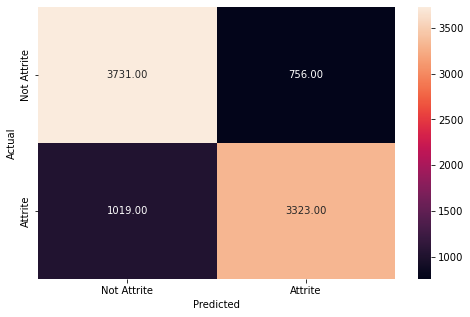

In [425]:
metrics_score(train_data['loan_status'].values,
              train_data['predicted_default'].values)

### Evaluate prediction accuracy on the testing data

In [431]:
test_data1['score'] = test_data1[cols].apply(lambda x: cal_score(x,ell),axis=1)

In [432]:
test_data1['predicted_default'] = np.where(test_data1['score']>bd,1,0)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.78      0.88      1861

    accuracy                           0.78      1861
   macro avg       0.50      0.39      0.44      1861
weighted avg       1.00      0.78      0.88      1861



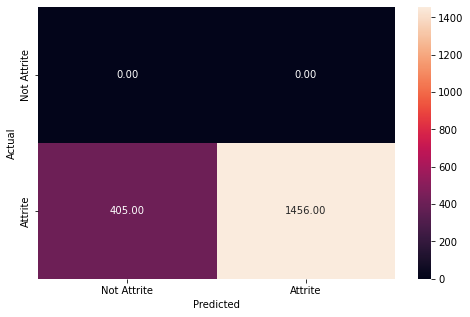

In [433]:
metrics_score(test_data1['loan_status'].values,
              test_data1['predicted_default'].values)

              precision    recall  f1-score   support

           0       1.00      0.83      0.91     17948
           1       0.00      0.00      0.00         0

    accuracy                           0.83     17948
   macro avg       0.50      0.41      0.45     17948
weighted avg       1.00      0.83      0.91     17948



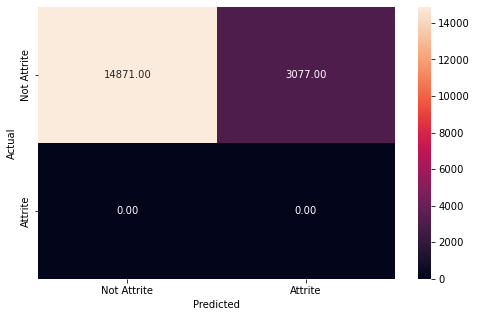

In [434]:
test_data0['score'] = test_data0[cols].apply(lambda x: cal_score(x,ell),axis=1)
test_data0['predicted_default'] = np.where(test_data0['score']>bd,1,0)
metrics_score(test_data0['loan_status'].values,
              test_data0['predicted_default'].values)

## Logistic Regression Analysis

In [436]:
Y_train = train_data['loan_status'].values
X_train = train_data[cols].values

In [437]:
clf = LogisticRegression(random_state=0).fit(X_train, Y_train)

In [438]:
predict_status = clf.predict(X_train)

              precision    recall  f1-score   support

           0       0.79      0.83      0.81      4487
           1       0.82      0.77      0.79      4342

    accuracy                           0.80      8829
   macro avg       0.80      0.80      0.80      8829
weighted avg       0.80      0.80      0.80      8829



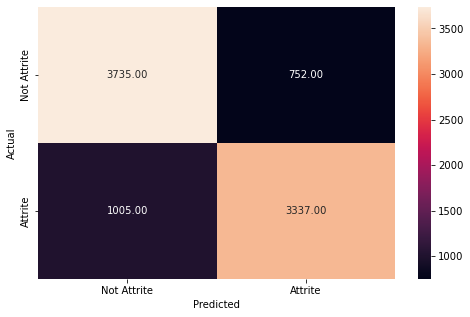

In [439]:
metrics_score(Y_train, predict_status)

### Prediction on Class 1

In [440]:
X_test1 = test_data1[cols].values

In [441]:
Y_test1 = test_data1['loan_status'].values
Y_test1

array([1, 1, 1, ..., 1, 1, 1])

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.79      0.88      1861

    accuracy                           0.79      1861
   macro avg       0.50      0.39      0.44      1861
weighted avg       1.00      0.79      0.88      1861



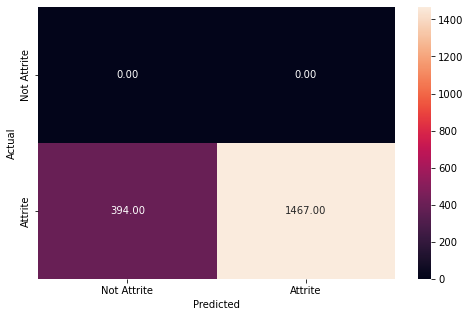

In [442]:
predict_status1 = clf.predict(X_test1)
metrics_score(Y_test1, predict_status1)

### Prediction on Class 0

In [443]:
X_test0 = test_data0[cols].values
Y_test0 = test_data0['loan_status'].values

              precision    recall  f1-score   support

           0       1.00      0.83      0.91     17948
           1       0.00      0.00      0.00         0

    accuracy                           0.83     17948
   macro avg       0.50      0.41      0.45     17948
weighted avg       1.00      0.83      0.91     17948



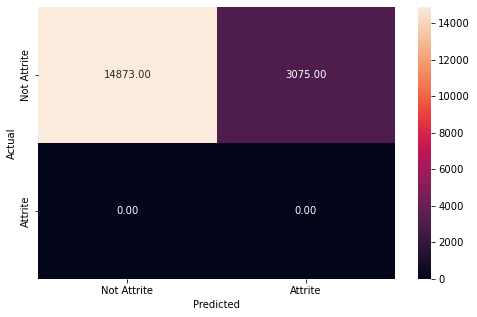

In [444]:
predict_status0 = clf.predict(X_test0)
metrics_score(Y_test0, predict_status0)